In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
from skimage.graph import route_through_array
import rasterio
import geopandas as gpd

from gridfinder._util import save_raster, clip_line_poly
from gridfinder.prepare import merge_rasters, create_filter, prepare_ntl, prepare_roads
from gridfinder import gridfinder as gf
from gridfinder.post import threshold, accuracy, guess2geom

# Merge monthly rasteres

In [ ]:
folder = Path.home() / 'Documents/GIS/VIIRS_Uganda_2016_monthly'

raster_merged = merge_rasters(folder, percentile=70)
plt.imshow(raster_merged, vmin=0, vmax=1)

In [ ]:
raster_merged_out, affine = folder / 'VIIRS_Uganda_p70.tif'
save_raster(raster_merged_out, raster_merged, affine)

# Create filter

In [3]:
ntl_filter = create_filter()

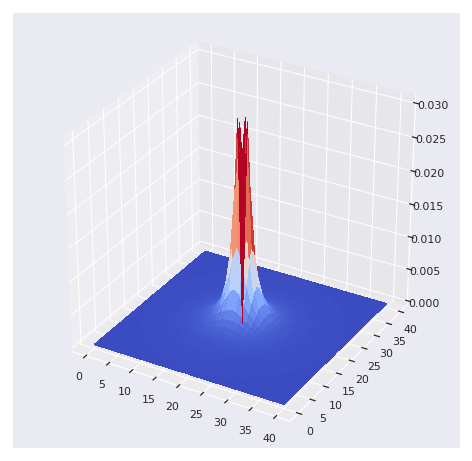

In [4]:
X = np.fromfunction(lambda i, j: i, ntl_filter.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.shape)

fig = plt.figure(figsize=(8,8))
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Clip, filter and resample NTL

In [5]:
#ntl_in = Path.home() / 'Documents/GIS/VIIRS_Africa_2016.tif'

folder = Path('uganda_big')
ntl_in = folder / 'VIIRS_Uganda_p70.tif'
aoi_in = folder / 'uganda.gpkg'

In [6]:
ntl, ntl_filtered, ntl_interp, ntl_thresh, affine = prepare_ntl(ntl_in, aoi_in,
                                                                ntl_filter=ntl_filter,
                                                                threshold=2.1,
                                                                upsample_by=2)

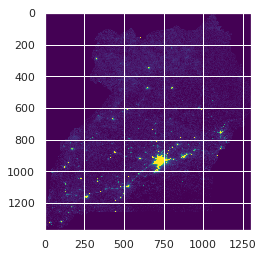

In [8]:
plt.imshow(ntl, cmap='viridis', vmin=0, vmax=1)

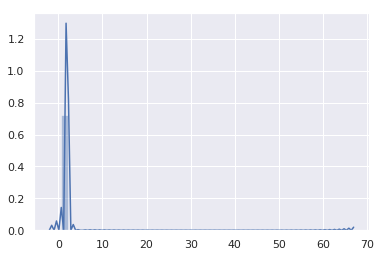

In [14]:
sns.distplot(ntl_filtered.flatten())

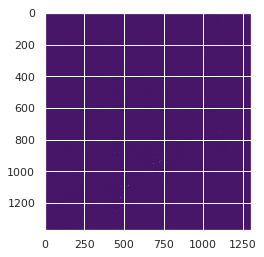

In [16]:
plt.imshow(ntl_filtered, cmap='viridis')

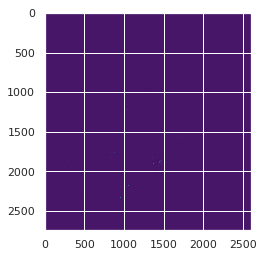

In [17]:
plt.imshow(ntl_interp, cmap='viridis')

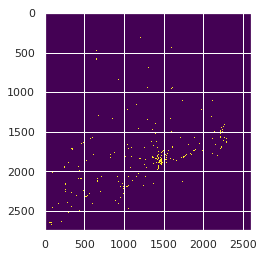

In [18]:
plt.imshow(ntl_thresh, cmap='viridis')

In [19]:
ntl_out = folder / 'ntl.tif'
save_raster(ntl_out, ntl_thresh, affine)

# Roads: assign values, clip and rasterize

In [32]:
roads_in = folder / 'uganda_roads.gpkg'
aoi_in = folder / 'uganda.gpkg'

In [33]:
roads, roads_clipped, aoi, roads_raster, affine = prepare_roads(roads_in, aoi_in, ntl_thresh.shape, affine)

In [34]:
roads.head(2)

,highway,geometry,weight
0,service,"LINESTRING (32.657798 0.3479249, 32.6580256 0....",0.333333
1,service,"LINESTRING (32.6591916 0.3490086, 32.6591718 0...",0.333333


In [35]:
len(roads)

157800

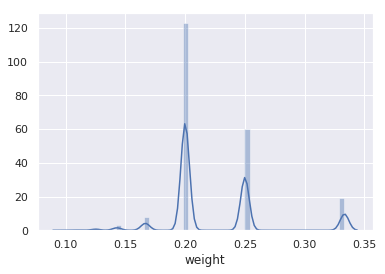

In [36]:
sns.distplot(roads['weight'])

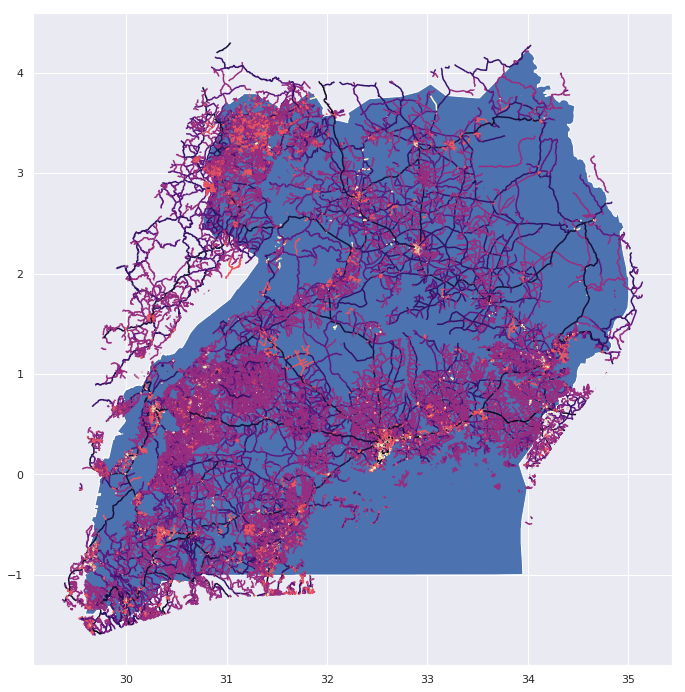

In [37]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
roads.plot(ax=ax, column='weight', cmap='magma')
aoi.plot(ax=ax)
plt.show()

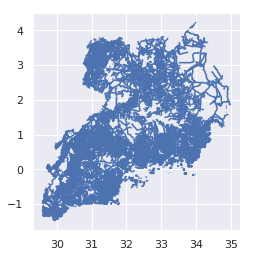

In [38]:
roads_clipped.plot()

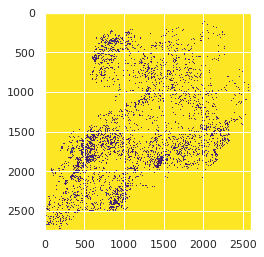

In [39]:
plt.imshow(roads_raster, cmap='viridis')

In [40]:
roads_out = folder / 'roads_raster.tif'
save_raster(roads_out, roads_raster, affine)

# skimage basic example
http://scikit-image.org/docs/dev/api/skimage.graph.html

In [25]:
image = np.array([[1,  1,   1,   1,   3],
                  [1,  1,   1,   0.5, 0.1],
                  [1,  1,   1,   0.5, 0.1],
                  [1,  1,   0.5, 1,   0.1],
                  [2,  0.5, 0.1,   0.1,   0.1]])
image

array([[1. , 1. , 1. , 1. , 3. ],
       [1. , 1. , 1. , 0.5, 0.1],
       [1. , 1. , 1. , 0.5, 0.1],
       [1. , 1. , 0.5, 1. , 0.1],
       [2. , 0.5, 0.1, 0.1, 0.1]])

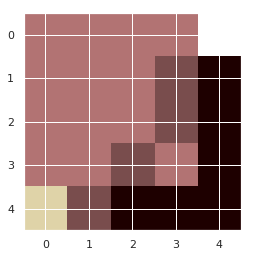

In [26]:
plt.imshow(image, cmap='pink')

In [27]:
# image[row, col]
image[4,0], image[0,4]

(2.0, 3.0)

In [28]:
indices, weight = route_through_array(image, [4, 0], [0, 4], fully_connected=True, geometric=True)
indices, weight

([(4, 0), (4, 1), (4, 2), (4, 3), (3, 4), (2, 4), (1, 4), (0, 4)],
 3.5414213562373096)

In [29]:
indices = np.array(indices).T
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1
path

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0.]])

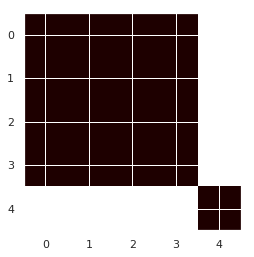

In [30]:
plt.imshow(path, cmap='pink')

# Convert targets to list of coordinates

In [37]:
folder = Path('uganda_big')
targets_in = folder / 'ntl.tif'
costs_in = folder / 'roads.tif'

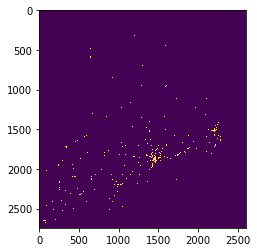

In [38]:
targets, transform, start = gf.get_targets(targets_in)
plt.imshow(targets, cmap='viridis')

In [39]:
targets.shape

(2744, 2606)

In [40]:
start

(37, 2116)

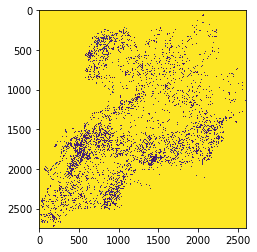

In [41]:
costs = gf.get_costs(costs_in)
plt.imshow(costs, cmap='viridis')

In [42]:
costs.shape

(2744, 2606)

# Test targets and roads data

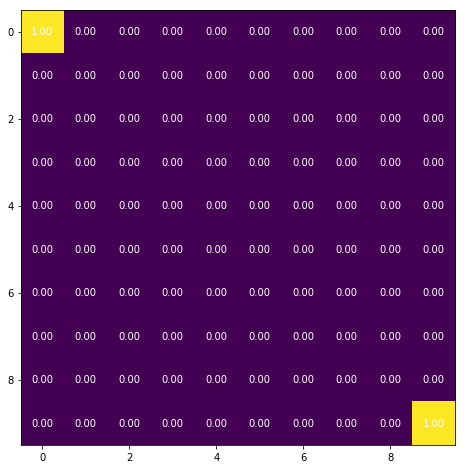

In [45]:
targets_test = np.zeros((10, 10))
targets_test[0, 0] = 1
targets_test[9, 9] = 1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(targets_test, cmap='viridis')
for (j,i),label in np.ndenumerate(targets_test):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center', color='white')

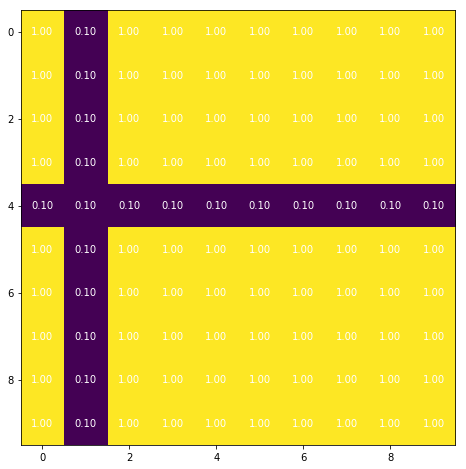

In [46]:
costs_test = np.ones_like(targets_test)
costs_test[:,1] = 0.1
costs_test[4,:] = 0.1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(costs_test, cmap='viridis')
for (j,i),label in np.ndenumerate(costs_test):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center', color='white')

In [47]:
start_test = (0,0)

# Some quick speed tests

In [79]:
%%timeit
gf.optimise(targets_test, costs_test, start_test, use_direction=True)

4.82 ms ± 88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
%%timeit
gf.optimise(targets_test, costs_test, start_test, use_direction=False)

4.77 ms ± 76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Run algorithm!

In [52]:
#dist = gf.optimise(targets_test, costs_test, start_test, display_progress=True)
dist = gf.optimise(targets, costs, start, display_progress=True, use_direction=False)

'1.00%'

KeyboardInterrupt: 

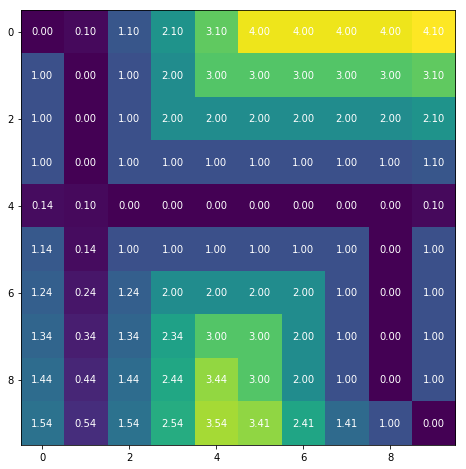

In [49]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(dist, cmap='viridis')
for (j,i),label in np.ndenumerate(dist):
    ax.text(i, j, f'{label:.2f}', ha='center', va='center', color='white')

In [11]:
dist_out = folder / 'dist.tif'
save_raster(dist_out, dist_gen, transform)

# Filter dist results to grid guess

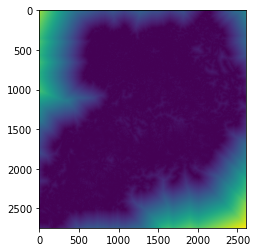

In [12]:
dists_in = folder / 'dist.tif'
dists_r, guess, transform = threshold(dists_in, cutoff=0.5)
plt.imshow(dists_r, cmap='viridis')

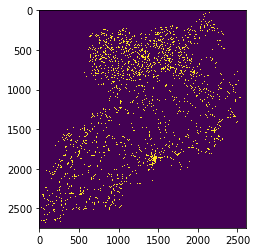

In [13]:
plt.imshow(guess, cmap='viridis')

In [14]:
guess_out = folder / 'guess-0.5.tif'
save_raster(guess_out, guess, transform)

# Check results

In [15]:
grid_in = folder / 'uganda_grid.gpkg'
guess_in = folder / 'guess-0.5.tif'
aoi_in = folder / 'uganda.gpkg'

true_pos, false_neg = accuracy(grid_in, guess_in, aoi_in)

In [16]:
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')

Points identified as grid that are grid: 36%


In [17]:
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

Actual grid that was missed: 29%


# Convert to geometry

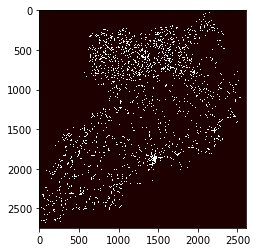

In [18]:
guess_in = folder / 'guess-0.5.tif'
guess_r, guess_geojson, guess_gdf = guess2geom(guess_in)
plt.imshow(guess_r, cmap='pink')

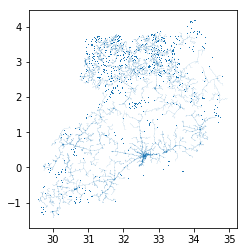

In [19]:
guess_gdf.plot()

In [20]:
guess_gdf.head()

,geometry,val
0,"POLYGON ((34.03333402527554 4.179168125506692,...",1.0
1,"POLYGON ((33.99375069362018 4.17083479251115, ...",1.0
2,"POLYGON ((33.99166736037516 4.168751459262265,...",1.0
3,"POLYGON ((34.04791735799067 4.168751459262265,...",1.0
4,"POLYGON ((33.98958402713014 4.16666812601338, ...",1.0


In [21]:
guess_vec_out = folder / 'guess_vec.gpkg'
guess_gdf.to_file(guess_vec_out, driver='GPKG')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GPKG does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/uganda_big/guess_vec.gpkg does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/uganda_big/guess_vec.gpkg does not support layer creation option ENCODING
